In [1]:
import warnings

import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns

pal = sns.color_palette()

In [2]:
train_data = pd.read_csv('Data/train.csv')
train_data

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0
404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1
404287,404287,537928,537929,What is one coin?,What's this coin?,0
404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0


In [3]:
train_data.shape

(404290, 6)

In [4]:
# Number of duplicate question pairs

train_data['is_duplicate'].sum()

149263

Text(0, 0.5, 'Probability')

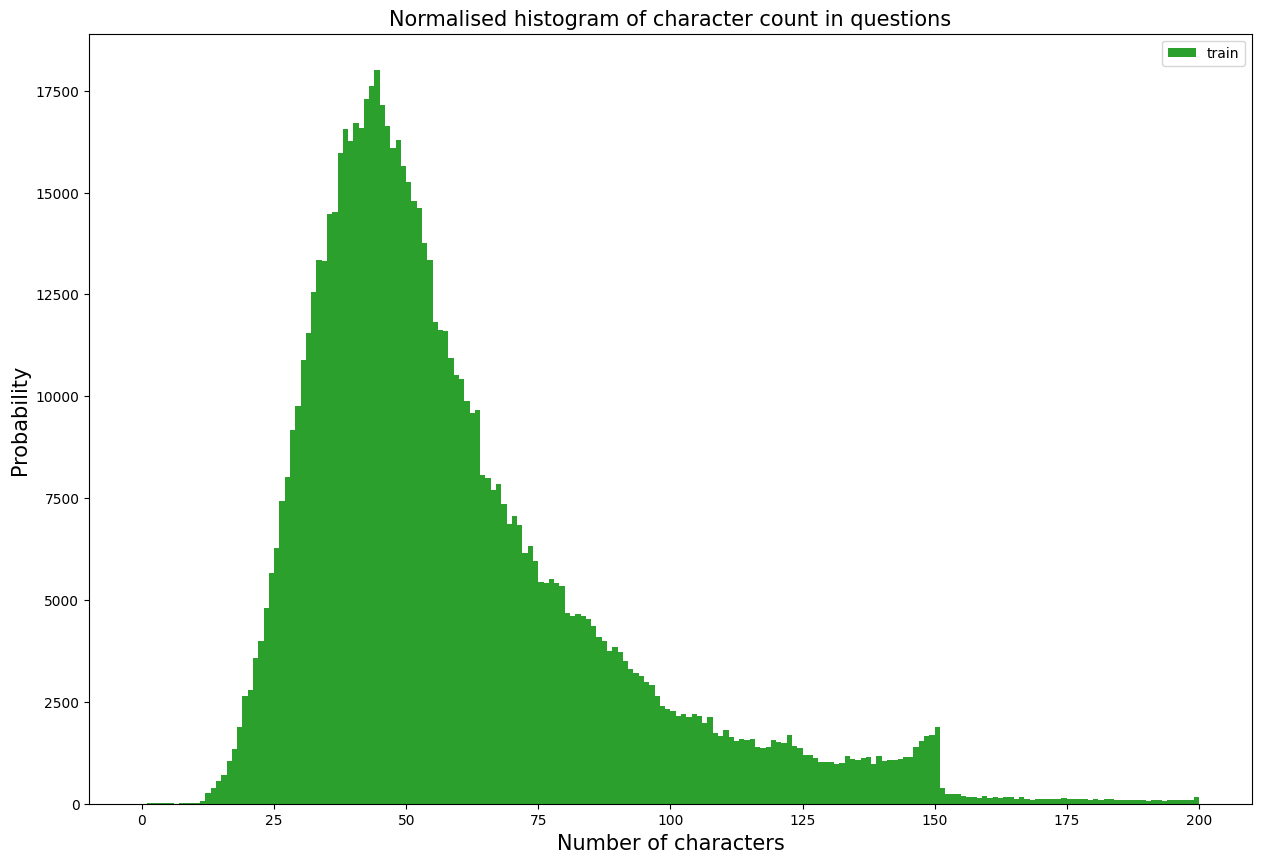

In [5]:
train_question_set = pd.Series(train_data['question1'].tolist() + train_data['question2'].tolist()).astype(str)

len_train = train_question_set.apply(len)

plt.figure(figsize=(15, 10))
plt.hist(len_train, bins=200, range=[0, 200], color=pal[2], label='train')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

In [ ]:
from wordcloud import WordCloud

cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_question_set.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

(-0.5, 1439.5, 1079.5, -0.5)

In [ ]:
# no_of_qmarks =

In [ ]:
train_data.head()

In [ ]:
from nltk.corpus import stopwords

stops = set(stopwords.words("english"))

def word_match(row):
    q1_words = {}
    q2_words = {}

    for word in str(row[3]).lower().split():
        if word not in stops:
            q1_words[word] = 1

    for word in str(row[4]).lower().split():
        if word not in stops:
            q2_words[word] = 1

    common_words_in_q1 = [word for word in q1_words.keys() if word in q2_words]
    common_words_in_q2 = [word for word in q2_words.keys() if word in q1_words]

    matching_prob = (len(common_words_in_q1) + len(common_words_in_q2)) / (len(q1_words) + len(q2_words))
    return matching_prob

plt.figure(figsize=(15, 5))
train_word_match = train_data.apply(word_match, axis=1, raw=True)
plt.hist(train_word_match[train_data['is_duplicate'] == 0], bins=20, label='Not Duplicate')
plt.hist(train_word_match[train_data['is_duplicate'] == 1], bins=20, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)


In [ ]:
probs = []
for i in range(len(train_data)):
    if i != 0:
        probs.append(word_match(train_data.iloc[i]))
probs

In [ ]:
from collections import Counter

def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (eps + count)

eps = 5000
words = (" ".join(train_question_set)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

In [ ]:
def tfidf_word_match(row):
    q1_words = {}
    q2_words = {}
    for word in str(row[3]).lower().split():
        if word not in stops:
            q1_words[word] = 1
    for word in str(row[4]).lower().split():
        if word not in stops:
            q2_words[word] = 1

    common_weights = [weights.get(word, 0) for word in q1_words.keys() if word in q2_words] + [weights.get(word, 0) for word in q2_words.keys() if word in q1_words]

    total_weights = [weights.get(word, 0) for word in q1_words] + [weights.get(word, 0) for word in q2_words]

    return np.sum(common_weights) / np.sum(total_weights)

In [ ]:
tfidf_train_word_match = train_data.apply(tfidf_word_match, axis=1, raw=True)

In [ ]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(train_data['is_duplicate'], train_word_match))
print(roc_auc_score(train_data['is_duplicate'], tfidf_train_word_match.fillna(0)))

In [ ]:
test_ratio = 0.3
test_size = int(train_data.shape[0] * test_ratio)
train_df = train_data[test_size:]
test_df = train_data[:test_size]

In [ ]:
train_df.shape, test_df.shape

In [ ]:
train_df['is_duplicate'].sum(), test_df['is_duplicate'].sum()

In [ ]:
train_word_match = train_df.apply(word_match, axis=1, raw=True)
tfidf_train_word_match = train_df.apply(tfidf_word_match, axis=1, raw=True)

In [ ]:
x_train = pd.DataFrame()
x_test = pd.DataFrame()

x_train['word_match'] = train_word_match
x_train['tfidf_word_match'] = tfidf_train_word_match
x_test['word_match'] = test_df.apply(word_match, axis=1, raw=True)
x_test['tfidf_word_match'] = test_df.apply(tfidf_word_match, axis=1, raw=True)

y_train = train_df['is_duplicate'].values

In [ ]:
duplicate_train = x_train[y_train == 1]
non_duplicate_train = x_train[y_train == 0]

p = 0.165
scale = ((len(duplicate_train) / (len(duplicate_train) + len(non_duplicate_train))) / p) - 1
while scale > 1:
    non_duplicate_train = pd.concat([non_duplicate_train, non_duplicate_train])
    scale -=1
non_duplicate_train = pd.concat([non_duplicate_train, non_duplicate_train[:int(scale * len(non_duplicate_train))]])

print(len(duplicate_train) / (len(duplicate_train) + len(non_duplicate_train)))

x_train = pd.concat([duplicate_train, non_duplicate_train])
y_train = (np.zeros(len(duplicate_train)) + 1).tolist() + np.zeros(len(non_duplicate_train)).tolist()
del duplicate_train, non_duplicate_train

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [ ]:
import xgboost as xgb

params = {}
params['objective'] = 'binary:logistic'
params['metric'] = 'logloss'
params['eta'] = 0.025
params['max_depth'] = 4

train = xgb.DMatrix(x_train, label=y_train)
valid = xgb.DMatrix(x_valid, label=y_valid)
watchlist = [(train, 'train'), (valid, 'valid')]

model = xgb.train(params, train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

In [ ]:
test = xgb.DMatrix(x_test)
prediction = model.predict(test)

output = pd.DataFrame()
output['is_duplicate'] = prediction
output.to_csv('output.csv', index=False)

In [ ]:
test_df

In [ ]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from bs4 import BeautifulSoup
import warnings

warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('Data/train.csv')
data.head()

In [ ]:
def preprocess(f):

    f = str(f).lower().strip()

    f = f.replace('%', ' percent')
    f = f.replace('$', ' dollar ')
    f = f.replace('₹', ' rupee ')
    f = f.replace('€', ' euro ')
    f = f.replace('@', ' at ')

    f = f.replace('[math]', '')

    f = f.replace(',000,000,000 ', 'b ')
    f = f.replace(',000,000 ', 'm ')
    f = f.replace(',000 ', 'k ')
    f = re.sub(r'([0-9]+)000000000', r'\1b', f)
    f = re.sub(r'([0-9]+)000000', r'\1m', f)
    f = re.sub(r'([0-9]+)000', r'\1k', f)

    contractions = {
        "ain't": "am not",
        "aren't": "are not",
        "can't": "can not",
        "can't've": "can not have",
        "'cause": "because",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hadn't've": "had not have",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he would",
        "he'd've": "he would have",
        "he'll": "he will",
        "he'll've": "he will have",
        "he's": "he is",
        "how'd": "how did",
        "how'd'y": "how do you",
        "how'll": "how will",
        "how's": "how is",
        "i'd": "i would",
        "i'd've": "i would have",
        "i'll": "i will",
        "i'll've": "i will have",
        "i'm": "i am",
        "i've": "i have",
        "isn't": "is not",
        "it'd": "it would",
        "it'd've": "it would have",
        "it'll": "it will",
        "it'll've": "it will have",
        "it's": "it is",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightn't": "might not",
        "mightn't've": "might not have",
        "must've": "must have",
        "mustn't": "must not",
        "mustn't've": "must not have",
        "needn't": "need not",
        "needn't've": "need not have",
        "o'clock": "of the clock",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "shan't": "shall not",
        "sha'n't": "shall not",
        "shan't've": "shall not have",
        "she'd": "she would",
        "she'd've": "she would have",
        "she'll": "she will",
        "she'll've": "she will have",
        "she's": "she is",
        "should've": "should have",
        "shouldn't": "should not",
        "shouldn't've": "should not have",
        "so've": "so have",
        "so's": "so as",
        "that'd": "that would",
        "that'd've": "that would have",
        "that's": "that is",
        "there'd": "there would",
        "there'd've": "there would have",
        "there's": "there is",
        "they'd": "they would",
        "they'd've": "they would have",
        "they'll": "they will",
        "they'll've": "they will have",
        "they're": "they are",
        "they've": "they have",
        "to've": "to have",
        "wasn't": "was not",
        "we'd": "we would",
        "we'd've": "we would have",
        "we'll": "we will",
        "we'll've": "we will have",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what will",
        "what'll've": "what will have",
        "what're": "what are",
        "what's": "what is",
        "what've": "what have",
        "when's": "when is",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where is",
        "where've": "where have",
        "who'll": "who will",
        "who'll've": "who will have",
        "who's": "who is",
        "who've": "who have",
        "why's": "why is",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "won't've": "will not have",
        "would've": "would have",
        "wouldn't": "would not",
        "wouldn't've": "would not have",
        "y'all": "you all",
        "y'all'd": "you all would",
        "y'all'd've": "you all would have",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you would",
        "you'd've": "you would have",
        "you'll": "you will",
        "you'll've": "you will have",
        "you're": "you are",
        "you've": "you have"
    }

    f_decontracted = []

    for word in f.split():
        if word in contractions:
            word = contractions[word]

        f_decontracted.append(word)

    f = ' '.join(f_decontracted)
    f = f.replace("'ve", " have")
    f = f.replace("n't", " not")
    f = f.replace("'re", " are")
    f = f.replace("'ll", " will")

    f = BeautifulSoup(f)
    f = f.get_text()

    pattern = re.compile('\W')
    f = re.sub(pattern, ' ', f).strip()

    return f

In [ ]:
preprocess("I've already! wasn't <b>done</b>?")

In [ ]:
data['question1'] = data['question1'].apply(preprocess)
data['question2'] = data['question2'].apply(preprocess)

In [ ]:
data.head()

In [ ]:
data['q1_len'] = data['question1'].str.len()
data['q2_len'] = data['question2'].str.len()

In [ ]:
data['q1_num_words'] = data['question1'].apply(lambda row: len(row.split(" ")))
data['q2_num_words'] = data['question2'].apply(lambda row: len(row.split(" ")))
data.head()

In [ ]:
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return len(w1 & w2)

In [ ]:
data['common_words'] = data.apply(common_words, axis=1)
data.head()

In [ ]:
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return len(w1) + len(w2)

In [ ]:
data['total_words'] = data.apply(total_words, axis=1)
data.head()

In [ ]:
from nltk.corpus import stopwords

def fetch_token_features(row):

    q1 = row[3]
    q2 = row[4]

    SAFE_DIV = 0.0001
    STOP_WORDS = stopwords.words("english")

    token_features = [0.0] * 8

    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])

    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])

    common_word_count = len(q1_words.intersection(q2_words))
    common_stop_word_count = len(q1_stops.intersection(q2_stops))

    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))

    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_word_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_word_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_word_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)

    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])

    token_features[7] = int(q1_tokens[0] == q2_tokens[0])

    return token_features


In [ ]:
token_features = data.apply(fetch_token_features, axis=1)

data["cwc_min"] = list(map(lambda x: x[0], token_features))
data["cwc_max"] = list(map(lambda x: x[1], token_features))
data["csc_min"] = list(map(lambda x: x[2], token_features))
data["csc_max"] = list(map(lambda x: x[3], token_features))
data["ctc_min"] = list(map(lambda x: x[4], token_features))
data["ctc_max"] = list(map(lambda x: x[5], token_features))
data["last_word_eq"] = list(map(lambda x: x[6], token_features))
data["first_word_eq"] = list(map(lambda x: x[7], token_features))

In [ ]:
data.head()

In [ ]:
import distance

In [ ]:
def fetch_length_features(row):

    q1 = row[3]
    q2 = row[4]

    length_features = [0.0] * 3

    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features

    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    length_features[1] = (len(q1_tokens) + len(q2_tokens)) / 2

    strs = list(distance.lcsubstrings(q1, q2))
    if len(strs) > 0 and len(strs[0]) > 0:
        length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    else:
        length_features[2] = 0

    return length_features


In [ ]:
length_features = data.apply(fetch_length_features, axis=1)

data['abs_len_diff'] = list(map(lambda x: x[0], length_features))
data['mean_len'] = list(map(lambda x: x[1], length_features))
data['longest_substring_ratio'] = list(map(lambda x: x[2], length_features))

data.head()

FuzzyWuzzy is a library of Python which is used for string matching. Fuzzy string matching is the process of finding strings that match a given pattern. Basically it uses Levenshtein Distance to calculate the differences between sequences

In [ ]:
from fuzzywuzzy import fuzz

In [ ]:
def fetch_fuzzy_features(row):

    q1 = row[3]
    q2 = row[4]

    fuzzy_features = [0.0] * 4

    fuzzy_features[0] = fuzz.QRatio(q1, q2)
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [ ]:
fuzzy_features = data.apply(fetch_fuzzy_features, axis=1)

data['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
data['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
data['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
data['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

print(data.shape)
data.head()

In [ ]:
sns.pairplot(data[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']], hue='is_duplicate')

In [ ]:
sns.pairplot(data[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']], hue='is_duplicate')

In [ ]:
sns.pairplot(data[['last_word_eq', 'first_word_eq', 'is_duplicate']], hue='is_duplicate')

In [ ]:
sns.pairplot(data[['mean_len', 'abs_len_diff','longest_substring_ratio', 'is_duplicate']], hue='is_duplicate')

In [ ]:
sns.pairplot(data[['fuzz_ratio', 'fuzz_partial_ratio','token_sort_ratio','token_set_ratio', 'is_duplicate']], hue='is_duplicate')

In [ ]:
from sklearn.preprocessing import MinMaxScaler

x = MinMaxScaler().fit_transform(data[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substring_ratio']])
y = data['is_duplicate'].values

In [ ]:
# from sklearn.manifold import TSNE
#
# tsne_2d = TSNE(n_components=2, init='random', random_state=101, method='barnes_hut', n_iter=1000, verbose=2, angle=0.5).fit_transform(x)

In [ ]:
# x_df = pd.DataFrame({'x': tsne_2d[:, 0], 'y': tsne_2d[:, 1], 'label': y})
#
# sns.lmplot(data=x_df, x='x', y='y', hue='label', fit_reg=False, palette='Set1', markers=['s', 'o'])

In [ ]:
# tsne_3d = TSNE(n_components=3, init='random', random_state=101, method='barnes_hut', n_iter=1000, verbose=2, angle=0.5).fit_transform(x)

In [ ]:
ques_df = data[['question1', 'question2']]
ques_df.head()

In [ ]:
final_df = data.drop(columns=['id', 'qid1', 'qid2', 'question1', 'question2'])
print(final_df.shape)
final_df.head()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

questions = list(ques_df['question1']) + list(ques_df['question2'])

cv = CountVectorizer(max_features=3000)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(), 2)

In [ ]:
temp_df1 = pd.DataFrame(q1_arr, index=ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index=ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

In [ ]:
final_df = pd.concat([final_df, temp_df], axis=1)
print(final_df.shape)
final_df.head()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(final_df.iloc[:,1:].values, final_df.iloc[:,0].values,test_size=0.2,random_state=1)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier()
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
accuracy_score(y_test, y_pred)

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred1 = xgb.predict(X_test)
accuracy_score(y_test, y_pred1)

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix((y_test, y_pred))

In [ ]:
confusion_matrix((y_test, y_pred1))

In [ ]:
def test_common_words(q1, q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))

    return len(w1 & w2)


In [ ]:
def test_total_words(q1, q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))

    return len(w1) + len(w2)


In [ ]:
def fetch_test_token_features(q1, q2):

    q1_tokens = q1.split()
    q2_tokens = q2.split()

    SAFE_DIV = 0.0001
    STOP_WORDS = stopwords.words("english")

    token_features = [0.0] * 8

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])

    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])

    common_word_count = len(q1_words.intersection(q2_words))
    common_stop_word_count = len(q1_stops.intersection(q2_stops))

    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))

    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_word_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_word_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_word_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)

    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])

    token_features[7] = int(q1_tokens[0] == q2_tokens[0])

    return token_features


In [ ]:
def fetch_test_length_features(q1, q2):

    length_features = [0.0]*3

    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features

    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))

    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2

    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)

    return length_features

In [ ]:
def fetch_test_fuzzy_features(q1,q2):

    fuzzy_features = [0.0]*4
    fuzzy_features[0] = fuzz.QRatio(q1, q2)
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [ ]:
def query_point_creator(q1, q2):
    input_query = []
    q1 = preprocess(q1)
    q2 = preprocess(q2)

    input_query.append(len(q1))
    input_query.append(len(q2))

    input_query.append(len(q1.split(" ")))
    input_query.append(len(q2.split(" ")))

    input_query.append(test_common_words(q1, q2))
    input_query.append(test_total_words(q1, q2))
    input_query.append(round(test_common_words(q1, q2) / test_total_words(q1, q2)))

    token_features = fetch_test_token_features(q1, q2)
    input_query.extend(token_features)

    length_features = fetch_test_length_features(q1, q2)
    input_query.extend(length_features)

    fuzzy_features = fetch_test_fuzzy_features(q1, q2)
    input_query.extend(fuzzy_features)

    q1_bow = cv.transform([q1]).toarray()
    q2_bow = cv.transform([q2]).toarray()

    return np.hstack((np.array(input_query).reshape(1, 22), q1_bow, q2_bow))


In [ ]:
q1 = 'Where is the capital of India?'
q2 = 'What is the current capital of Pakistan?'
q3 = 'Which city serves as the capital of India?'
q4 = 'What is the business capital of India?'

In [ ]:
rf.predict(query_point_creator(q1, q4))

In [ ]:
rf.predict(query_point_creator(q1, q3))